# 5 bar mechanism dynamic analysis
This notebook presents the dynamic analysis of a 5 bar mechanism (2-RR) using generalized coordinates.

Author: Juan Pablo Reyes

In [1]:
import os
import sympy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

data_folder = os.path.abspath("data")

## 1. Theory



Generalized coordinates are a set of parameters that define the configuration of a system in the most compact form possible. For a rigid body in a plane, three generalized coordinates are required: two translational coordinates (x, y) and one rotational coordinate (ϕ). These parameters are grouped into a generalized coordinate vector:
<div align="center">

$q_i = \begin{bmatrix} x_i \\ y_i \\ \phi_i \end{bmatrix}$

![image](imgs/coords.png)

</div>




With this representation, any point in a body can be given by:
<div align="center">

$p_i = r_i + R s'_i$

</div>


  where:
  -  $r_i $ is the position of the body,
  -  $R$  is the rotation matrix,
  -  $s'_{i}$  is the local coordinate of the point relative to the body.

or in extended form:

<div align="center">

$\begin{bmatrix} p_{xi} \\ p_{yi} \end{bmatrix}=\begin{bmatrix} x_i \\ y_i \end{bmatrix}+\begin{bmatrix} \cos{\phi_i}& -\sin{\phi_i} \\ \sin{\phi_i} & \cos{\phi_i}\\ \end{bmatrix}\begin{bmatrix} s'_{xi} \\ s'_{yi}\end{bmatrix}$

![image](imgs/point.png)

</div>

### **Constraint Equations**
In mechanisms, multiple bodies are connected, restricting their motion. These constraints are expressed mathematically and reduce the system’s degrees of freedom (DoF). Constraints are classified into:

1. **Absolute Constraints** – These fix certain points or directions of motion relative to the ground:
   - **Rotational absolute constraint**: A body rotates around a fixed pivot.

        An absolute rotational constraint is given by the equations:
   
        <div align="center">

        $\begin{bmatrix} G_{x} \\ G_{y} \end{bmatrix}=\begin{bmatrix} x_i \\ y_i \end{bmatrix}+\begin{bmatrix} \cos{\phi_i}& -\sin{\phi_i} \\ \sin{\phi_i} & \cos{\phi_i}\\ \end{bmatrix}\begin{bmatrix} r'_{xi} \\ r'_{yi}\end{bmatrix}$

        </div>

   

        Where:

        $\vec{G}$ is the coordinate to the joint in the global reference frame

        $\vec{r}$ is the coordinate to the joint in the local reference frame of the body
   - **Translational absolute constraint**: A body moves along a prescribed path.
        
        An absolute translational constraint is given by the equations:

        <div align="center">

        $\vec{P_iQ_i} \cdot \vec{n}=0$ 

        $\vec{PP_i} \cdot \vec{n}=0$

        </div>

        Where:

        $\vec{PQ}$ is a line in the global reference frame generated by the points $P$ and $Q$, with a normal vector $\vec{n}$

        $\vec{P_iQi}$ is a line in the local reference frame of the body generated by the points $P_i$ and $Q_i$

        Note: The first equation constrains the line in the body defined by $\vec{P_iQi}$ to be parallel with $\vec{PQ}$, while the second equation constrains $P_i$ to be colinear with $\vec{PQ}$.

   - **Combined rotational-translational constraint**:
        This constraint is given with the second of the previous equations:

        <div align="center">

        $\vec{PP_i} \cdot \vec{n}=0$

        </div>

2. **Relative Constraints** – These specify relationships between moving bodies:
   - **Rotational relative constraint**: Two bodies share a common rotational pivot.


        An relative rotational constraint is given by the equations:
   
        <div align="center">

        $\begin{bmatrix} x_j \\ y_j \end{bmatrix}+\begin{bmatrix} \cos{\phi_j}& -\sin{\phi_j} \\ \sin{\phi_j} & \cos{\phi_j}\\ \end{bmatrix}\begin{bmatrix} r'_{xj} \\ r'_{yj}\end{bmatrix}=\begin{bmatrix} x_i \\ y_i \end{bmatrix}+\begin{bmatrix} \cos{\phi_i}& -\sin{\phi_i} \\ \sin{\phi_i} & \cos{\phi_i}\\ \end{bmatrix}\begin{bmatrix} r'_{xi} \\ r'_{yi}\end{bmatrix}$

        </div>

   

        Where:

        $\vec{r_i}$ is the coordinate to the joint in the local reference frame of the first body

        $\vec{r_j}$ is the coordinate to the joint in the local reference frame of the second body
   - **Translational relative constraint**: One body slides along another.
        
        A relative translational constraint is given by the equations:

        <div align="center">

        $\vec{P_iQ_i} \cdot \vec{n_j}=0$ 

        $\vec{P_jP_i} \cdot \vec{n_j}=0$

        </div>

        Where:

        $\vec{P_jQ_j}$ is a line in the local reference frame of the first body generated by the points $P_i$ and $Q_i$

        $\vec{P_iQi}$ is a line in the local reference frame of the second body generated by the points $P_i$ and $Q_i$, with a normal vector $\vec{n_j}$

        Note: The first equation constrains the line in the body defined by $\vec{P_iQi}$ to be parallel with $\vec{PQ}$, while the second equation constrains $P_i$ to be colinear with $\vec{PQ}$.

   - **Rotational-translational relative constraint**: A combination of relative motion types.

        This constraint is given with the only second of the previous equations:

        <div align="center">

        $\vec{P_jP_i} \cdot \vec{n_j}=0$

        </div>

Each constraint introduces one or more equations that limit the system's degrees of freedom.

### **Constraint Vector & Degrees of Freedom**
For a mechanism with $ n $ moving bodies in 2D space, the total number of generalized coordinates is:
<div align="center">

$
\text{Coords} = 3n
$

</div>


However, the number of  degrees of freedom is reduced by the constraints, giving:

<div align="center">

$
DoF = 3n - m
$

</div>


where $ m $ is the number of constraint equations. These constraints are grouped into a constraint vector:

<div align="center">

$
\Phi(q, t) = \begin{bmatrix} \Phi_K \\ \Phi_D \end{bmatrix} = 0
$

</div>


where:
- $ \Phi_K $ contains kinematic constraints imposed by joints.
- $ \Phi_D $ contains actuator-imposed constraints.


### **Kinematics of Mechanisms**
Kinematics describes how the mechanism moves without considering forces. It involves three key analyses:

#### **1. Position Analysis**
The system configuration at a given time is found by solving:

<div align="center">

$
\Phi(q, t) = 0
$

</div>


#### **2. Velocity Analysis**
Taking the time derivative of the constraint equations (using the total derivative):

<div align="center">

$
\frac{d}{dt} \Phi(q, t) = \Phi_q \dot{q} + \Phi_t = 0
$

</div>

Solving for **generalized velocities**:

<div align="center">

$
\dot{q} = -\Phi_q^{-1} \Phi_t
$
</div>


where:
- $ \Phi_q $ is the Jacobian matrix of constraint derivatives.

#### **3. Acceleration Analysis**
Taking the second derivative:

<div align="center">

$
\frac{d^2}{dt^2} \Phi(q, t) = \frac{d}{dt}(\Phi_q \dot{q} + \Phi_t)=(\Phi_q \dot{q})_q  \dot{q}+\Phi_q \ddot{q} + 2\Phi_{qt} \dot{q} + \Phi_{tt} = 0
$
</div>


Solving for **generalized accelerations**:

<div align="center">

$
\ddot{q} = -\Phi_q^{-1} \left[(\Phi_q \dot{q})_q  \dot{q}+2\Phi_{qt} \dot{q} + \Phi_{tt}\right]
$
</div>




### **Kinetics of Mechanisms**
Once the kinematics are established, the forces acting on the mechanism can be analyzed using D'Alembert's principle with Lagrange multipliers:

<div align="center">

$
M \ddot{q} = Q_a+\Phi_q^T \lambda
$
</div>


where:
- $ M(q) $ is the mass-inertia matrix.
- $Q_a$ are the external forces applied on the mechanism, such as the weight and external frictions
- $\lambda$ is a vector corresponding to the internal forces of the mechanism. **Important**: These forces represent the forces produced by each of the constraints, so the elements in this vector correspond to the forces produced by the respective constraint in $\Phi$ rather than being forces applied on each of the bodies.

This equation allows the computation of forces required to achieve a given motion.

## 0. Parameters and General variables

In [90]:
# Parameters
scale = 0.5

# Motor coordinates
O_1x, O_2x,O_1y, O_2y = -0.075 * scale, 0.075 * scale,0 * scale, 0 * scale

# Link lengths
L_p1, L_p2, L_d1, L_d2 = [0.2 * scale, 0.2 * scale, 0.4 * scale, 0.4 * scale]

# Masses an rotational interia
m_p=0.04628319
m_d=0.08628319
I_p=0.00005336
I_d=0.00033781

# Mass Matrix
M=np.diag([m_p,m_p,I_p,m_d,m_d,I_d,m_d,m_d,I_d,m_p,m_p,I_p])

# A known configuration for the mechanism
q_base=np.vstack([-0.14571*scale,0.07071*scale,np.deg2rad(135),
     -0.10821*scale,0.30962*scale,np.deg2rad(57.244623466),
     0.10821*scale,0.30962*scale,np.deg2rad(-57.244623466),
     0.14571*scale,0.07071*scale,np.deg2rad(-135)])

# Symbolic variables
t = sp.Symbol('t')

phi_p1, phi_p2, phi_d1, phi_d2 = sp.symbols('phi_p1 phi_p2 phi_d1 phi_d2')
x_p1, y_p1, x_p2, y_p2 = sp.symbols('x_p1 y_p1 x_p2 y_p2')
x_d1, y_d1, x_d2, y_d2 = sp.symbols('x_d1 y_d1 x_d2 y_d2')

dphi_p1, dphi_p2, dphi_d1, dphi_d2 = sp.symbols('dphi_p1 dphi_p2 dphi_d1 dphi_d2')
dx_p1, dy_p1, dx_p2, dy_p2 = sp.symbols('dx_p1 dy_p1 dx_p2 dy_p2')
dx_d1, dy_d1, dx_d2, dy_d2 = sp.symbols('dx_d1 dy_d1 dx_d2 dy_d2')

# Rotation matrix function (symbolic and numeric)
def rotmat(phi):
    return sp.Matrix([[sp.cos(phi), -sp.sin(phi)], [sp.sin(phi), sp.cos(phi)]])

def rotmat_num(phi):
    return np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])

# Generalized coordinates vector
q = sp.Matrix([x_p1, y_p1, phi_p1, x_d1, y_d1, phi_d1, x_d2, y_d2, phi_d2, x_p2, y_p2, phi_p2])
dq = sp.Matrix([dx_p1, dy_p1, dphi_p1, dx_d1, dy_d1, dphi_d1, dx_d2, dy_d2, dphi_d2, dx_p2, dy_p2, dphi_p2])

# Number of generalized coordinates
nq=len(q)

# The inverse is defined as a symolic variable to avoid the analytical calculation of the inverse of the jacobian
inv_PHI_q=sp.MatrixSymbol('inv_PHI_q', nq, nq)

# Joint equations

# Proximal link 1 - Ground
eq1 = sp.Matrix([x_p1, y_p1]) + rotmat(phi_p1) * sp.Matrix([-L_p1 / 2, 0]) - sp.Matrix([O_1x, O_1y])

# Proximal link 1 - Distal Link 1
eq2 = sp.Matrix([x_p1, y_p1]) + rotmat(phi_p1) * sp.Matrix([L_p1 / 2, 0]) - (sp.Matrix([x_d1, y_d1]) + rotmat(phi_d1) * sp.Matrix([-L_d1 / 2, 0]))

#  Proximal link 1 - Distal Link 1
eq3 = sp.Matrix([x_d1, y_d1]) + rotmat(phi_d1) * sp.Matrix([L_d1 / 2, 0]) - (sp.Matrix([x_d2, y_d2]) + rotmat(phi_d2) * sp.Matrix([-L_d2 / 2, 0]))

# Distal Link 2 - Proximal Link 2
eq4 = sp.Matrix([x_d2, y_d2]) + rotmat(phi_d2) * sp.Matrix([L_d2 / 2, 0]) - (sp.Matrix([x_p2, y_p2]) + rotmat(phi_p2) * sp.Matrix([-L_p2 / 2, 0]))

# Proximal Link 2 - Ground
eq5 = sp.Matrix([x_p2, y_p2]) + rotmat(phi_p2) * sp.Matrix([L_p2 / 2, 0]) - sp.Matrix([O_2x, O_2y])

## 2. Analysis of the effector following a straight line

In [91]:
# Initial position, velocity, and angle for effector rectilinear motion
p_x_0, p_y_0,v_lin,theta_act = -0.12 * scale, 0.3 * scale , 0.1, np.deg2rad(30)

# Actuation Equations
eq6 = sp.Matrix([p_x_0 + t * v_lin * sp.cos(theta_act), p_y_0 + t * v_lin * sp.sin(theta_act)]) - sp.Matrix([x_d1, y_d1]) - rotmat(phi_d1) * sp.Matrix([L_d1 / 2, 0])

# Constraint vector
PHI = sp.simplify(sp.Matrix.vstack(eq1, eq2, eq3, eq4, eq5, eq6))

# Calculates Jacobian
PHI_q = PHI.jacobian(q)

# Analytical total derivatives
dq_eq=-inv_PHI_q@PHI.diff(t)
ddq_eq=-inv_PHI_q@(((PHI_q@dq).jacobian(q))@dq+2*PHI_q.diff(t)@dq+PHI.diff(t, t))

# Convert symbolic expressions to numerical functions
PHI_fun = sp.lambdify((q, t), PHI, 'numpy')
PHI_q_fun = sp.lambdify((q, t), PHI_q, 'numpy')

dq_fun = sp.lambdify((q, t,inv_PHI_q), dq_eq, 'numpy')
ddq_fun = sp.lambdify((q, dq, t,inv_PHI_q), ddq_eq, 'numpy')

In [92]:
# Newton - Rhapson Solver Parameters
tol=1e-6
max_iters=100

# Time array
time=np.arange(0,2,0.01)

# Initial feasible configuration
q_0=q_base.copy()

# Preallocation of arrays
qs=np.zeros((nq,len(time)))
dqs=np.zeros((nq,len(time)))
ddqs=np.zeros((nq,len(time)))
lambdas=np.zeros((nq,len(time)))

for i in tqdm(range(len(time))):
    j=1 # Reset iteration counter
    while True:
        phi_val=PHI_fun(q_0.flatten(),time[i]) # Calculates Phi
        
        inv_phi_q_val=np.linalg.inv(PHI_q_fun(q_0.flatten(),time[i])) # Calculates the inverse of the jacobian of Phi
        
        q_1=q_0-inv_phi_q_val@phi_val # Newton Rhapson Update
        
        # End if the tolerance is satisfied or raise exception if the max iterations are reached
        if j>max_iters:
            raise Exception("Solution could not be determined")
        if max(abs(phi_val))<=tol:
            qs[:,i]=q_0.flatten()
            dqs[:,i]=dq_fun(q_0.flatten(), time[i],inv_phi_q_val).flatten()
            ddqs[:,i]=ddq_fun(q_0.flatten(),dqs[:,i] ,time[i],inv_phi_q_val).flatten()
            Q_a=np.vstack(np.zeros(nq))
            lambdas[:,i]=((inv_phi_q_val.T)@(M@np.vstack(ddqs[:,i])-Q_a)).flatten()
            break
        q_0=q_1
        j+=1

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 902.32it/s]


In [93]:
# Animates the trajectory using lines
fig, ax = plt.subplots()
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect('equal')

mecha, = ax.plot([], [], 'bo-', lw=2)  
ax.plot(np.linspace(-0.4, 0.4, 100), p_y_0 + np.tan(theta_act) * (np.linspace(-0.4, 0.4, 100) - p_x_0), 'r--')

all_pts=[]

for i in range(len(time)):
    q_act = qs[:, i]
    
    all_pts.append(np.column_stack([
        [q_act[0], q_act[1]] + rotmat_num(q_act[2]) @ np.array([-L_p1/ 2, 0]),
        [q_act[0], q_act[1]] + rotmat_num(q_act[2]) @ np.array([L_p1 / 2, 0]),
        [q_act[3], q_act[4]] + rotmat_num(q_act[5]) @ np.array([L_d1 / 2, 0]),
        [q_act[9], q_act[10]] + rotmat_num(q_act[11]) @ np.array([-L_p2 / 2, 0]),
        [q_act[9], q_act[10]] + rotmat_num(q_act[11]) @ np.array([L_p2 / 2, 0])
    ]))

# Animation update function
def update(i):
    mecha.set_data(all_pts[i][0, :], all_pts[i][1, :])  # Update the line data
    return mecha,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(0, len(time), 5), interval=20, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

Text(0.5, 0.98, 'Dynamic Analysis')

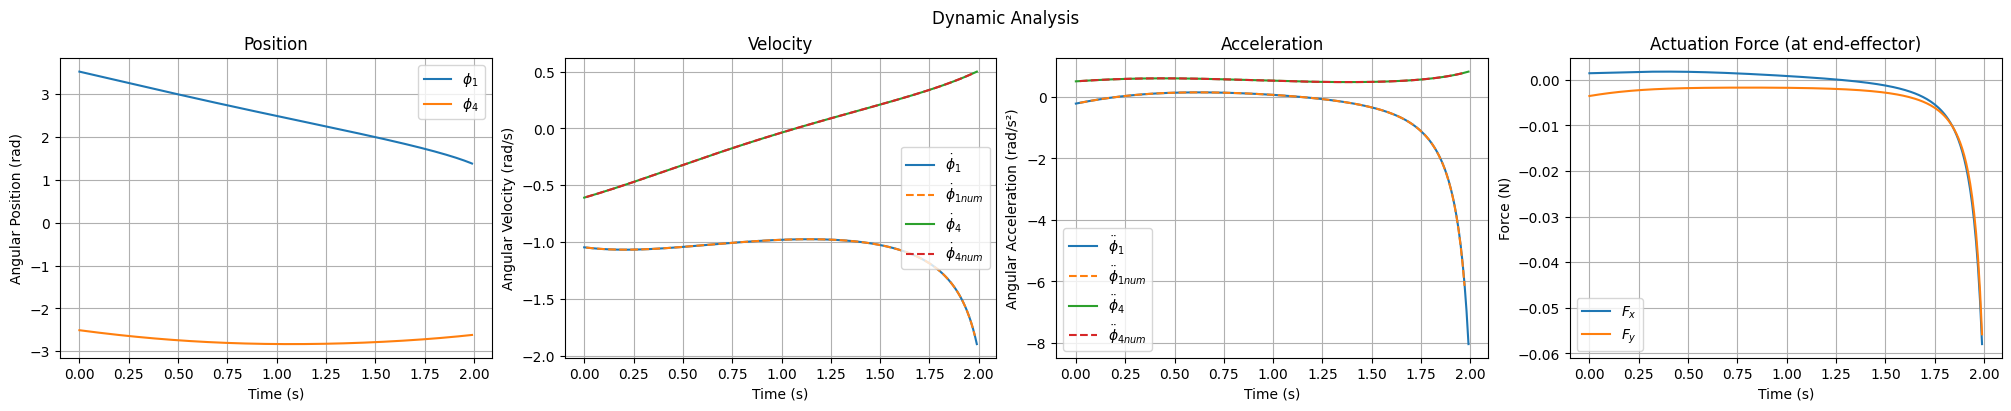

In [94]:
# Graphs (Compares analytical derivatives with numerical derivatives)
fig, axs = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)  # Increased figure width and added layout adjustment

# Position
axs[0].plot(time, qs[2, :], label="$\phi_1$")
axs[0].plot(time, qs[11, :], label="$\phi_4$")
axs[0].set_title("Position")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Angular Position (rad)")
axs[0].legend()
axs[0].grid(True)

# Velocity
axs[1].plot(time, dqs[2, :], label="$\dot{\phi}_1$")
axs[1].plot(time[1:-1], np.gradient(qs[2, :], time)[1:-1], '--', label="$\dot{\phi}_{1 num}$")
axs[1].plot(time, dqs[11, :], label="$\dot{\phi}_4$")
axs[1].plot(time[1:-1], np.gradient(qs[11, :], time)[1:-1], '--', label="$\dot{\phi}_{4 num}$")
axs[1].set_title("Velocity")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angular Velocity (rad/s)")
axs[1].legend()
axs[1].grid(True)

# Acceleration
axs[2].plot(time, ddqs[2, :], label="$\ddot{\phi}_1$")
axs[2].plot(time[2:-2], np.gradient(np.gradient(qs[2, :], time), time)[2:-2], '--', label="$\ddot{\phi}_{1 num}$")
axs[2].plot(time, ddqs[11, :], label="$\ddot{\phi}_4$")
axs[2].plot(time[2:-2], np.gradient(np.gradient(qs[11, :], time), time)[2:-2], '--', label="$\ddot{\phi}_{4 num}$")
axs[2].set_title("Acceleration")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Angular Acceleration (rad/s²)")
axs[2].legend()
axs[2].grid(True)

# Actuation Forces
axs[3].plot(time, lambdas[10, :], label="$F_x$")
axs[3].plot(time, lambdas[11, :], label="$F_y$")
axs[3].set_title("Actuation Force (at end-effector)")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Force (N)")
axs[3].legend()
axs[3].grid(True)

plt.suptitle("Dynamic Analysis")


In [95]:
# Record data
df = pd.DataFrame({
    "time": time,
    "q1": qs[2, :],
    "q2": qs[11, :],
    "dq1": dqs[2, :],
    "dq2": dqs[11, :]
})
df.to_parquet(os.path.join(data_folder, "trajectory_data.parquet"), index=False)

## 3. Workspace Calculation

In [96]:
# Symbolic variables for the angles of the actuators
sym_phi_p1, sym_phi_p2 = sp.symbols('sym_phi_p1 sym_phi_p2')

# Actuation Equations
eq6 = sp.Matrix([phi_p1, phi_p2]) - sp.Matrix([sym_phi_p1, sym_phi_p2])

# Constraint vector
PHI = sp.simplify(sp.Matrix.vstack(eq1, eq2, eq3, eq4, eq5, eq6))

# Calculates Jacobian
PHI_q = PHI.jacobian(q)

# Convert symbolic expressions to numerical functions
PHI_fun = sp.lambdify((q, sym_phi_p1,sym_phi_p2), PHI, 'numpy')
PHI_q_fun = sp.lambdify((q, sym_phi_p1,sym_phi_p2), PHI_q, 'numpy')

In [110]:
# Newton - Rhapson Solver Parameters
tol=1e-6
max_iters=100

configurations=int(1e5)

# Initial feasible configuration
q_0=q_base.copy()

qs=np.zeros((nq,configurations))
effs=np.zeros((2,configurations))

qs[:,0]=q_0.flatten()
effs[:,0]=[qs[3,0], qs[4,0]] + rotmat(qs[5,0]) @ np.array([L_d1 / 2, 0])

for i in tqdm(range(1,configurations)):
    
    j=1 # Reset iteration counter
    q_ant=qs[:,np.random.randint(i)] # Pick random solution from the ones solved
    q_0=np.vstack(q_ant) # Use random solution as the initial guess for the next iteration

    # Select random orientations for the proximal links
    theta1=np.random.rand()*(2*np.pi)
    theta2=np.random.rand()*(-2*np.pi)
    
    while True:
        phi_val=PHI_fun(q_0.flatten(),theta1,theta2) # Calculate Phi
        
        inv_phi_q_val=np.linalg.inv(PHI_q_fun(q_0.flatten(),theta1,theta2)) # Calculate the inverse of the jacobian of Phi
        
        q_1=q_0-inv_phi_q_val@phi_val # Newton Rhapson Update
        
        if j>max_iters:
            qs[:,i]=q_ant.flatten()
            effs[:,i]=[qs[3,i], qs[4,i]] + rotmat_num(qs[5,i]) @ np.array([L_d1 / 2, 0])
            break
        if max(abs(phi_val))<=tol:
            qs[:,i]=q_0.flatten()
            effs[:,i]=[qs[3,i], qs[4,i]] + rotmat_num(qs[5,i]) @ np.array([L_d1 / 2, 0])

            break
        q_0=q_1
        j+=1

100%|██████████| 99999/99999 [04:19<00:00, 384.75it/s]


In [111]:
# Animates the trajectory using lines
fig, ax = plt.subplots()
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect('equal')

mecha, = ax.plot([], [], 'bo-', lw=2)  

all_pts=[]

for i in range(configurations):
    q_act = qs[:, i]
    
    all_pts.append(np.column_stack([
        [q_act[0], q_act[1]] + rotmat_num(q_act[2]) @ np.array([-L_p1/ 2, 0]),
        [q_act[0], q_act[1]] + rotmat_num(q_act[2]) @ np.array([L_p1 / 2, 0]),
        [q_act[3], q_act[4]] + rotmat_num(q_act[5]) @ np.array([L_d1 / 2, 0]),
        [q_act[9], q_act[10]] + rotmat_num(q_act[11]) @ np.array([-L_p2 / 2, 0]),
        [q_act[9], q_act[10]] + rotmat_num(q_act[11]) @ np.array([L_p2 / 2, 0])
    ]))

# Animation update function
def update(i):
    mecha.set_data(all_pts[i][0, :], all_pts[i][1, :])  # Update the line data
    return mecha,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(0, configurations, int(configurations/10)), interval=500, blit=True)
plt.close(fig)
HTML(ani.to_jshtml())

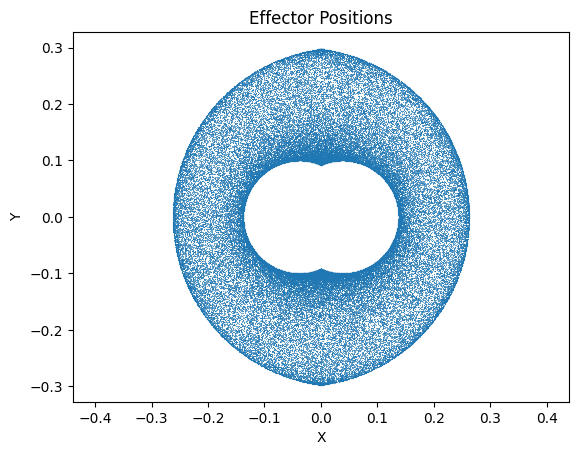

In [113]:

plt.plot(effs[0, :], effs[1, :], '*', markersize=0.1)  # Plot with '*' markers
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Effector Positions")
plt.axis("equal")  # Ensures equal scaling on both axes
plt.show()

In [58]:
print(effs[:,0])

[3.39059054e-07 2.38908825e-01]
